In [1]:
import os

import numpy as np
import pandas as pd
import time
pd.options.mode.chained_assignment = None
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings('ignore')

In [5]:
bldgs = os.listdir('Consumption/Batch 1')
bldg_id = [b.replace('-0.parquet', '') for b in bldgs]
AEC = {'TimeStamp':pd.read_parquet(f'Consumption/Batch 1/{bldgs[0]}', engine='pyarrow')['timestamp'].values}
for entry in bldgs:
    AEC[entry.replace('-0.parquet', '') + '-1'] = pd.read_parquet(f'Consumption/Batch 1/{entry}', engine='pyarrow')['out.electricity.total.energy_consumption'].values
    AEC[entry.replace('-0.parquet', '') + '-2'] = pd.read_parquet(f'Consumption/Batch 2/{entry}', engine='pyarrow')['out.electricity.total.energy_consumption'].values
AEC = pd.DataFrame(AEC)
'''for_2 = ['178170-2', '168545-2', '137153-2', '134097-2','133362-1',
         '132785-2','131194-1','130482-1', '126881-2', '126802-2', '123985-1',
         '127313-1']
for_3 = ['128353-1']'''
'''for c in for_2:
    AEC[c] = AEC[c]/2
for c in for_3:
    AEC[c] = AEC[c]/3'''
AEC.to_csv('Consumption/TexasRWConsumption15.csv', index=None)

In [6]:
data = pd.read_csv('Consumption/TexasRWConsumption15.csv')
data['weekday'] = [datetime.strptime(data['TimeStamp'].iloc[i], "%Y-%m-%d  %H:%M:%S").weekday() + 1 for i in range(len(data))]
entries1 = [c for c in data.columns[1:-1] if '-1' in c]
entries2 = [c for c in data.columns[1:-1] if '-2' in c]
data['aggregation-1'] = sum(data[entry] for entry in entries1)
data['aggregation-2'] = sum(data[entry] for entry in entries2)
data.to_csv('Consumption/TexasRWConsumption15.csv')

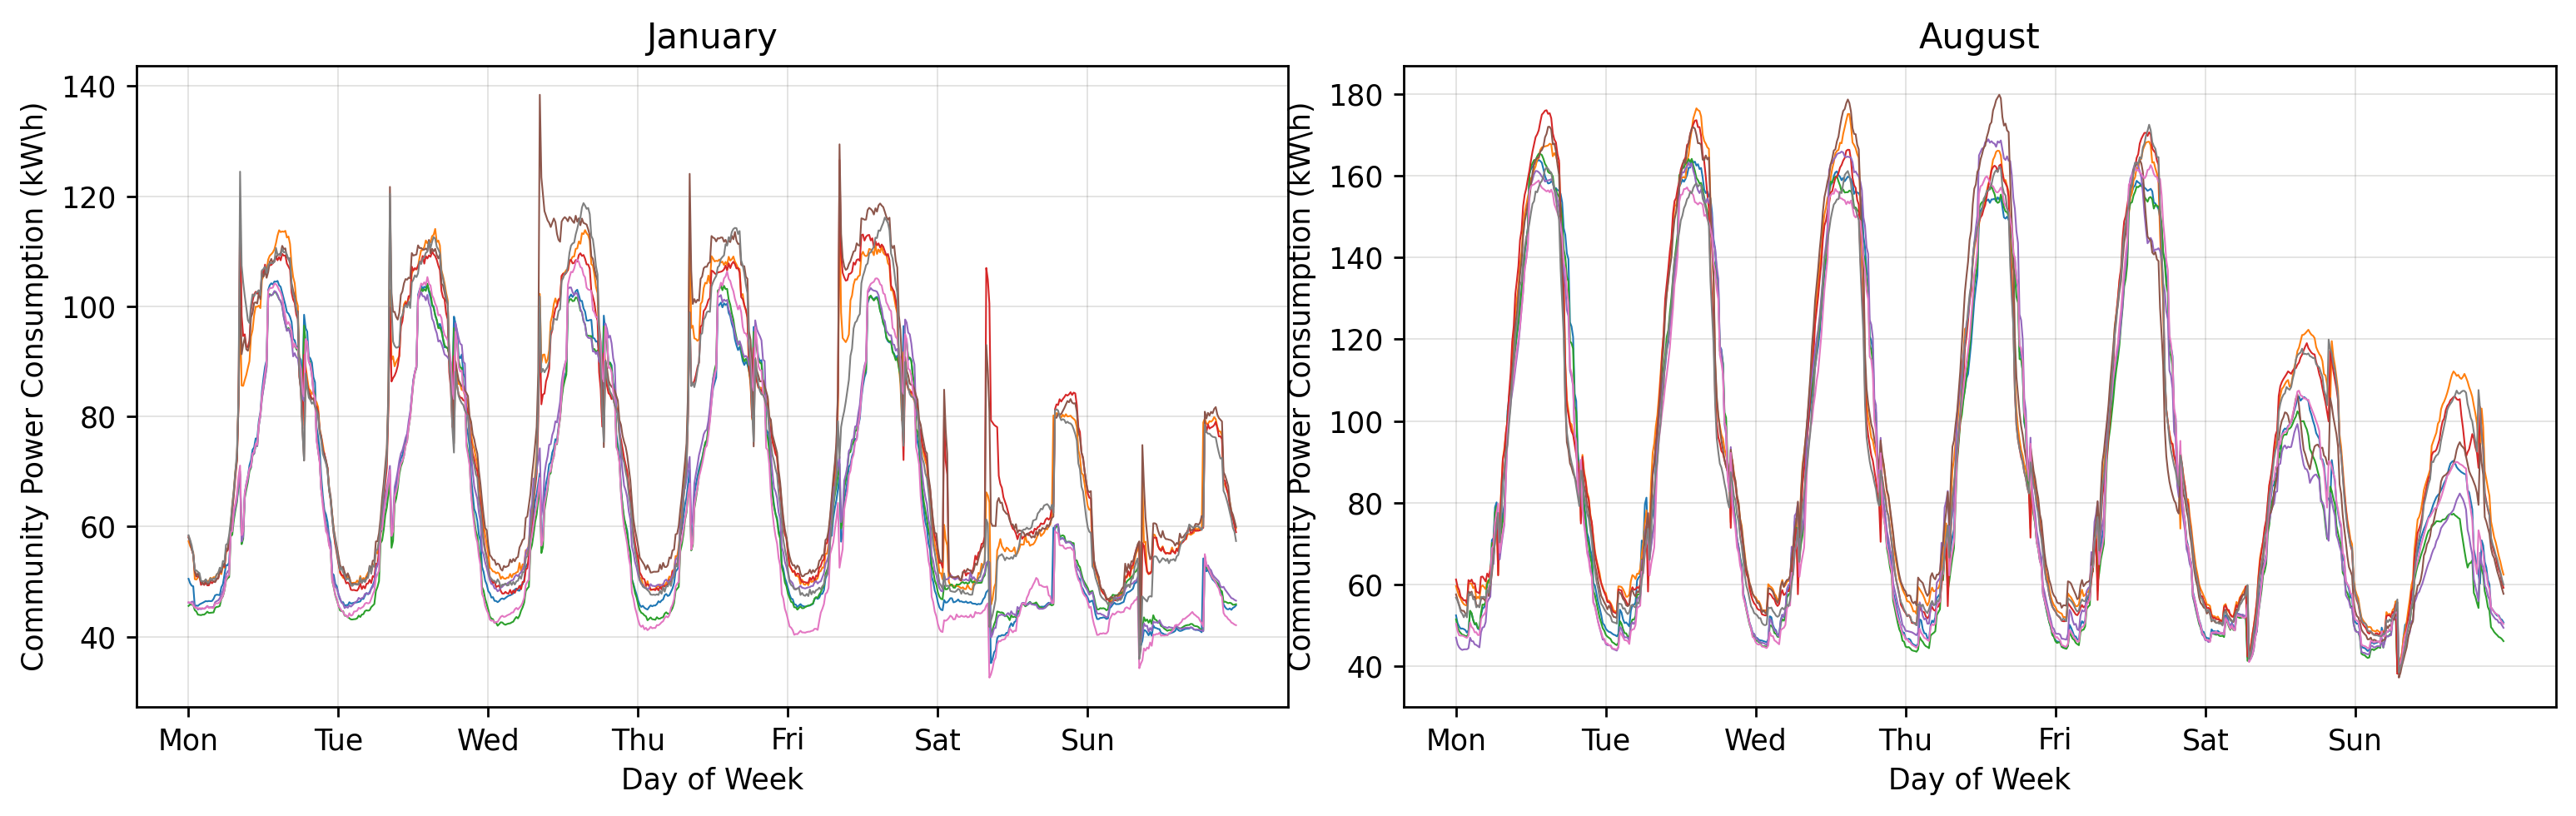

In [7]:
data = pd.read_csv('Consumption/TexasRWConsumption15.csv')
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=250)
h = 7*24*4
c = 4
j_start = (31+29+31+31+30+31+31)*24*4
for d in range(c):
    axs[0].plot(range(h), data['aggregation-1'].iloc[d*h: (d+1)*h], linewidth=0.6)
    axs[0].plot(range(h), data['aggregation-2'].iloc[d*h: (d+1)*h], linewidth=0.6)

while True:
    if data['weekday'].iloc[j_start] != 1:
        j_start -= 24*4
    else:
        break

for d in range(c):
    axs[1].plot(range(h), data['aggregation-1'].iloc[j_start + d*h: j_start + (d+1)*h], linewidth=0.6)
    axs[1].plot(range(h), data['aggregation-2'].iloc[j_start + d*h: j_start + (d+1)*h], linewidth=0.6)

axs[0].set_title('January')
axs[1].set_title('August')

axs[0].set_xticks([24*4*i for i in range(7)], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axs[1].set_xticks([24*4*i for i in range(7)], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

axs[0].set_xlabel('Day of Week')
axs[0].set_ylabel('Community Power Consumption (kW\h)')
axs[0].grid(color='#666362', linestyle='-', linewidth=0.1)

axs[1].set_xlabel('Day of Week')
axs[1].set_ylabel('Community Power Consumption (kW\h)')
axs[1].grid(color='#666362', linestyle='-', linewidth=0.1)
plt.subplots_adjust(wspace=0.1)
plt.savefig('IMG/Jan-Aug.jpg', bbox_inches='tight')

### Months Separation

In [8]:
months = {'JanFeb': 31+29, 'MarApr': 31+30, 'MayJun': 31+30,
          'JulAug': 31+31, 'SepOct': 30+31, 'NovDec': 31+31,}
all_months = {}
Start = 0
resolution = 24*4
for m in months:
    lenght = months[m]
    truncated = data.iloc[Start * resolution: (Start + lenght) * resolution]
    weekday = truncated[truncated['weekday'] < 6]
    weekend = truncated[truncated['weekday'] >= 6]
    wd = range(int(len(weekday)/resolution))
    we = range(int(len(weekend)/resolution))
    month_consumption = pd.DataFrame(index=range(resolution),
                                     columns=[f'weekday{j}-{i}' for i in (1, 2) for j in wd] +
                                             [f'weekend{j}-{i}' for i in (1, 2) for j in we])
    for j in wd:
        month_consumption[f'weekday{j}-1'] = weekday['aggregation-1'].iloc[j*resolution : (j+1)*resolution].values
        month_consumption[f'weekday{j}-2'] = weekday['aggregation-2'].iloc[j*resolution : (j+1)*resolution].values
    for j in we:
        month_consumption[f'weekend{j}-1'] = weekend['aggregation-1'].iloc[j*resolution : (j+1)*resolution].values
        month_consumption[f'weekend{j}-2'] = weekend['aggregation-2'].iloc[j*resolution : (j+1)*resolution].values
    Start += lenght
    all_months[m] = month_consumption

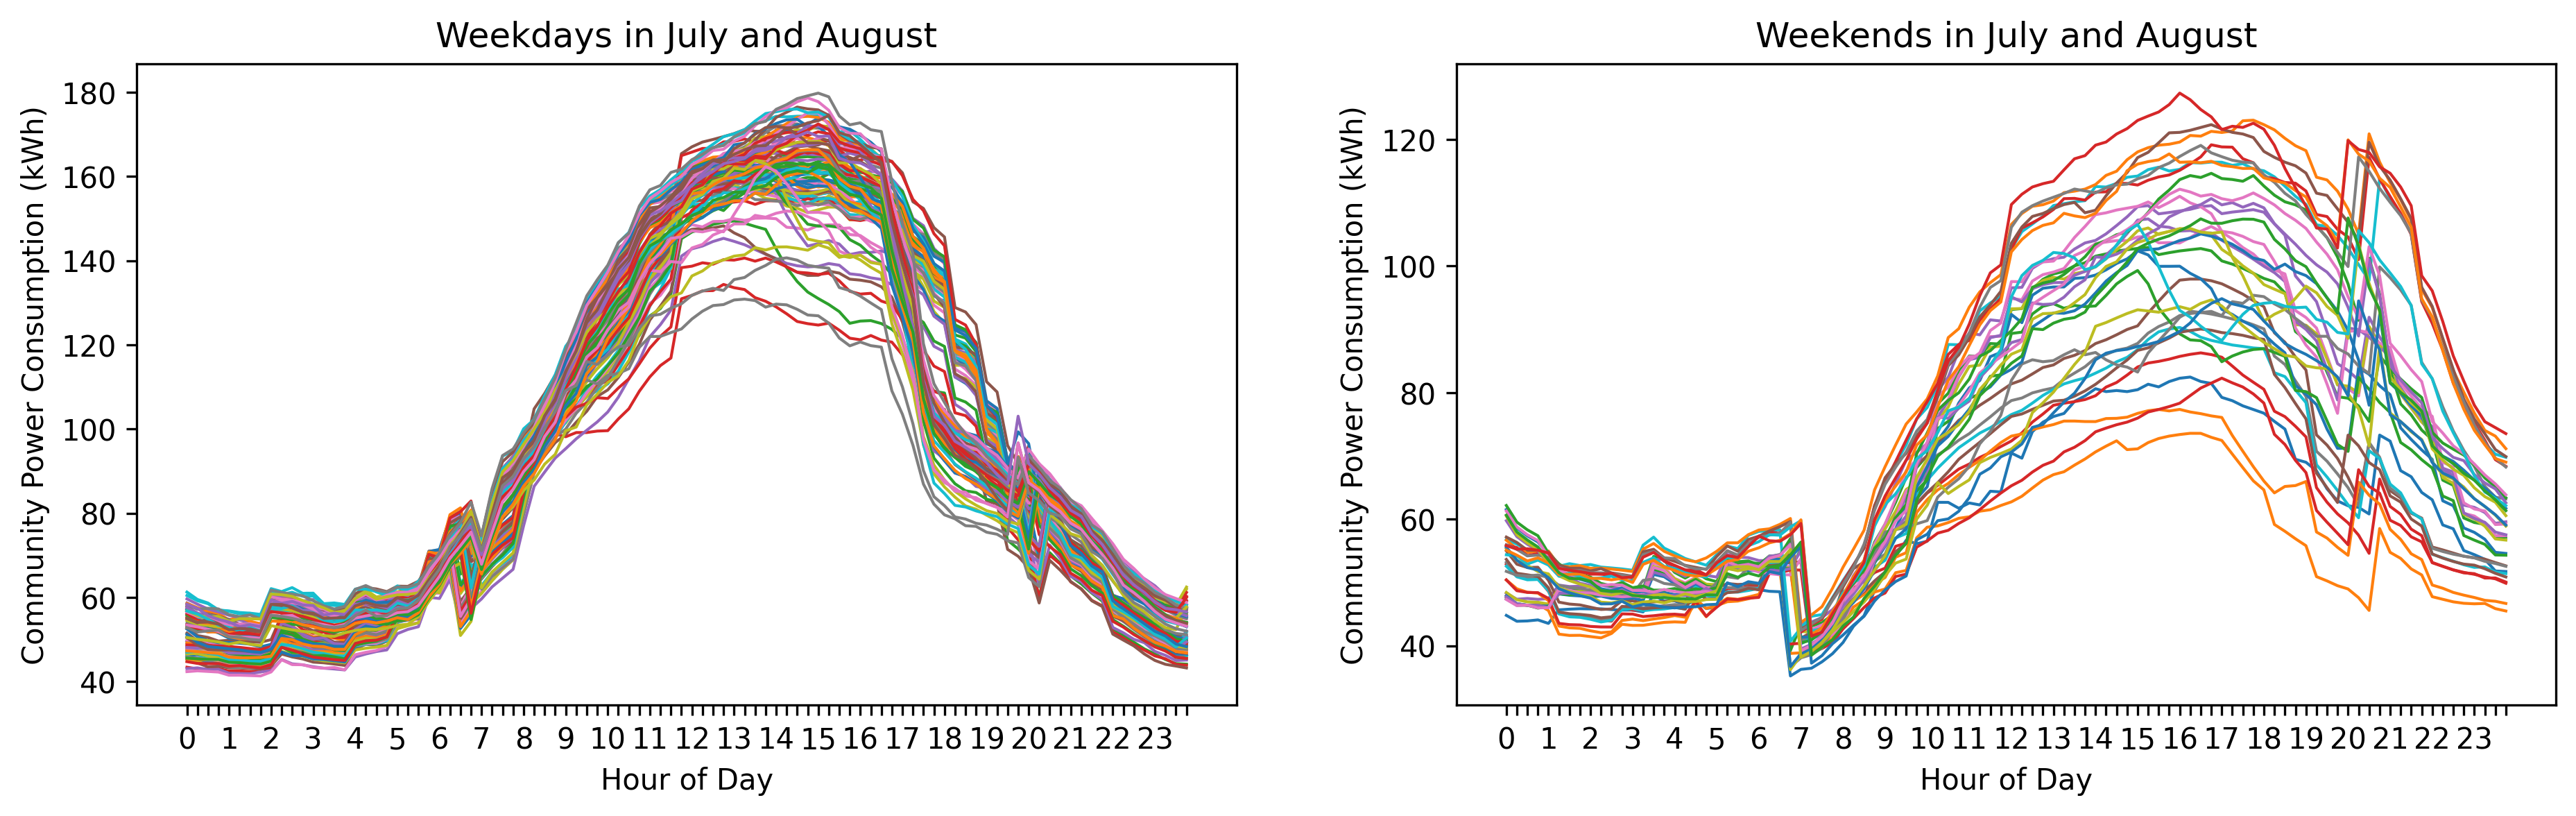

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=300)
for j in all_months['JulAug'].columns:
    if 'weekday' in j:
        axs[0].plot(range(resolution), all_months['JulAug'][j].values, linewidth=1)
    else:
        axs[1].plot(range(resolution), all_months['JulAug'][j].values, linewidth=1)

axs[0].set_title('Weekdays in July and August')
axs[1].set_title('Weekends in July and August')

axs[0].set_xlabel('Hour of Day')
axs[1].set_xlabel('Hour of Day')

axs[0].set_ylabel('Community Power Consumption (kWh)')
axs[1].set_ylabel('Community Power Consumption (kWh)')

ticks = []
for i in range(resolution):
    if i%4 == 0:
        ticks.append(str(int(i/4)))
    else:
        ticks.append('')
axs[0].set_xticks(range(resolution), ticks)
axs[1].set_xticks(range(resolution), ticks)
plt.savefig('IMG/Weekday-Weekend-JulAug.jpg', bbox_inches='tight')

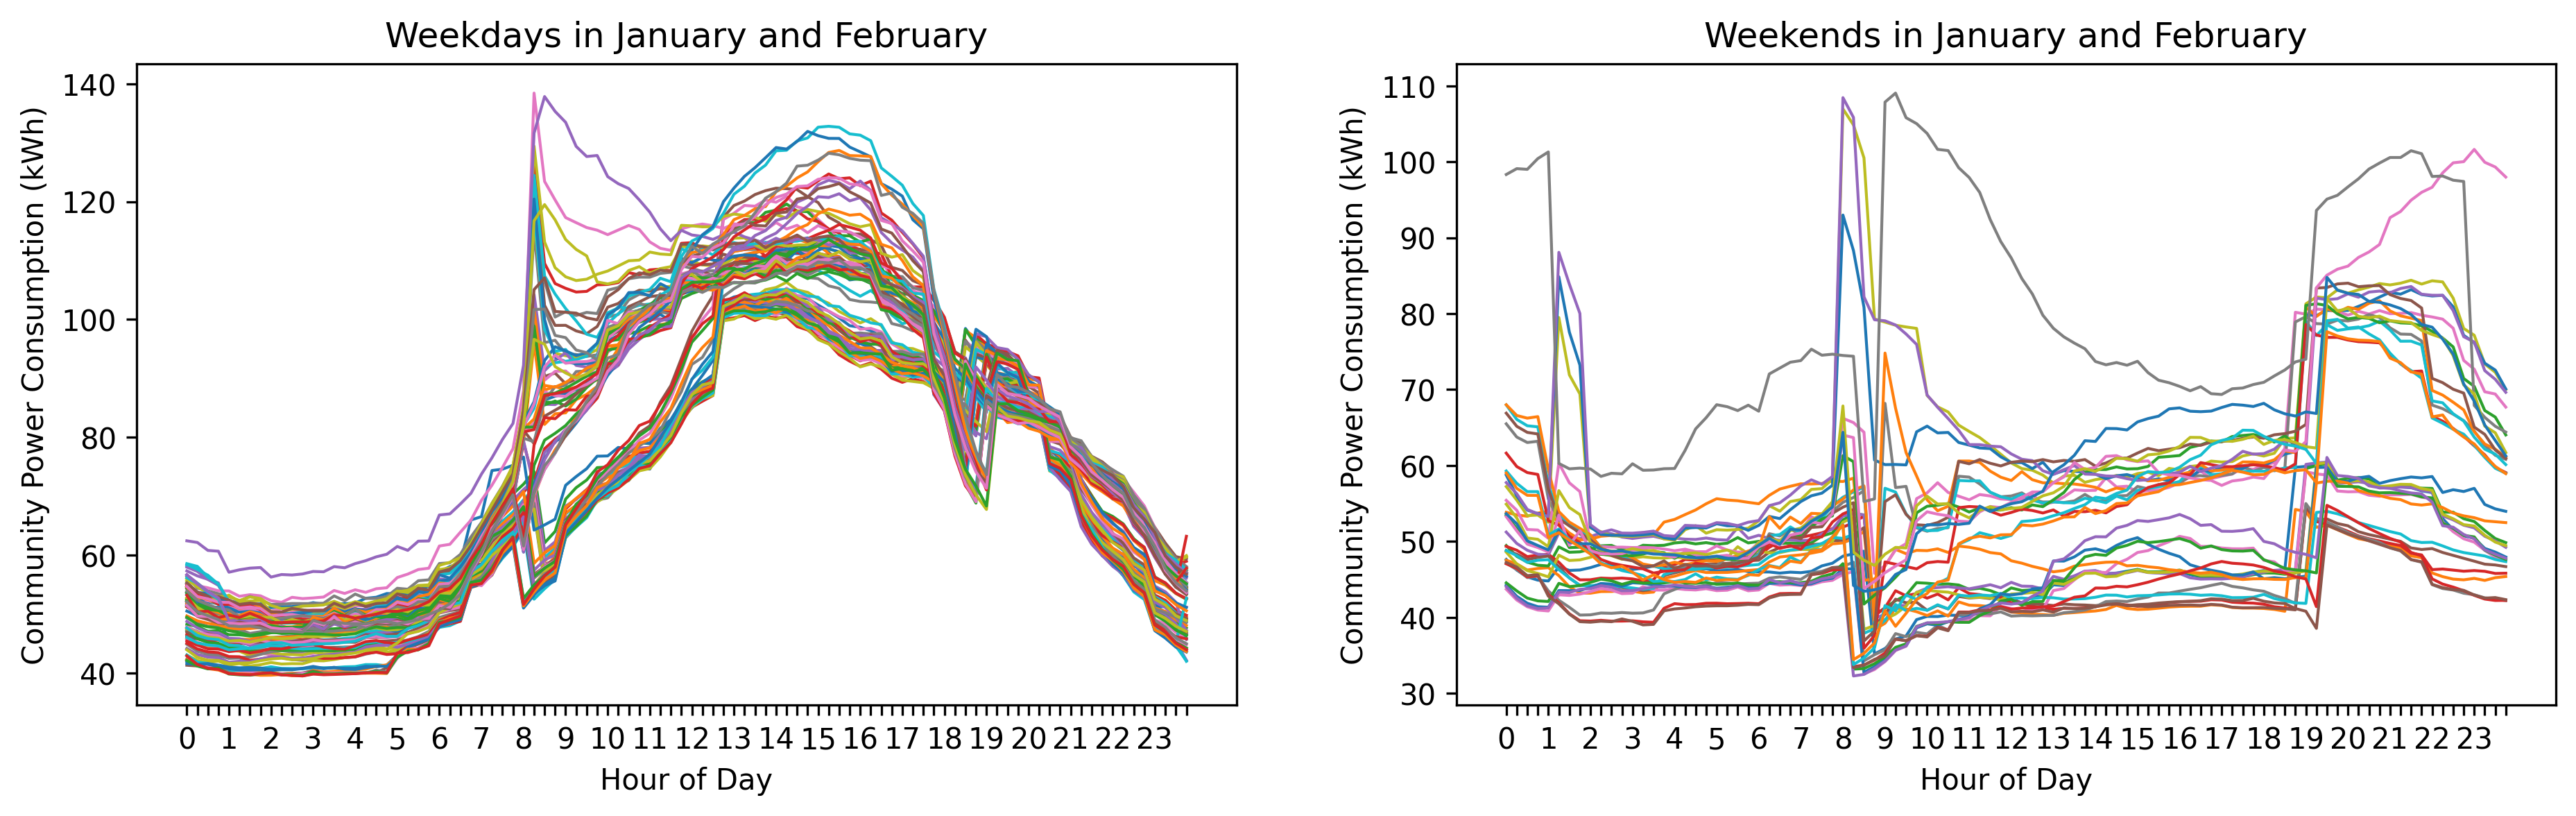

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=300)
for j in all_months['JanFeb'].columns:
    if 'weekday' in j:
        axs[0].plot(range(resolution), all_months['JanFeb'][j], linewidth=1)
    else:
        axs[1].plot(range(resolution), all_months['JanFeb'][j], linewidth=1)

axs[0].set_title('Weekdays in January and February')
axs[1].set_title('Weekends in January and February')

axs[0].set_xlabel('Hour of Day')
axs[1].set_xlabel('Hour of Day')

axs[0].set_ylabel('Community Power Consumption (kWh)')
axs[1].set_ylabel('Community Power Consumption (kWh)')

axs[0].set_xticks(range(resolution), ticks)
axs[1].set_xticks(range(resolution), ticks)
plt.savefig('IMG/Weekday-Weekend-JanFeb.jpg', bbox_inches='tight')

In [11]:
for m in months:
    weekday_list = [c for c in all_months[m].columns if 'weekday' in c]
    weekend_list = [c for c in all_months[m].columns if 'weekend' in c]

    counter = 1
    while counter <= 200:
        c1 = random.choice(weekday_list)
        while True:
            c2 = random.choice(weekday_list)
            if c2 != c1:
                break
        all_months[m][f'weekdayG-{counter}'] = 0.5*(all_months[m][c1].values + all_months[m][c2].values) + np.array([np.random.randn() for _ in all_months[m][c2].values])

        c1 = random.choice(weekend_list)
        while True:
            c2 = random.choice(weekend_list)
            if c2 != c1:
                break
        all_months[m][f'weekendG-{counter}'] = 0.5*(all_months[m][c1].values + all_months[m][c2].values) + np.array([np.random.randn() for _ in all_months[m][c2].values])
        counter += 1
    all_months[m].to_csv(f'ForGAN/{m}.csv')


In [ ]:
income = pd.read_csv('area_median_income_and_income_lookup.csv')
income_list = []
for b in bldg_id:
    income_list.append(income[income['bldg_id'] == int(b)]['in.household_income'].iloc[0])

plt.figure(figsize=(8, 5), dpi=300)
plt.hist(income_list, bins=20, color='orange')
plt.xlabel('Simulated Data Annual Income')
plt.ylabel('Frequency')
plt.title(f'Median Income: Survey(\$62500.0) - Simulated(\${np.median(income_list):0.1f})')
plt.savefig('IMG/Income.jpg', bbox_inches='tight')